# **Comparative Analysis of European Option Pricing using Binomial Trees and Black-Scholes Model**

First we import the necessary libraries


In [38]:
import numpy as np
import pandas as pd
from math import log, sqrt, exp
from scipy.stats import norm
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

## **Binomial Tree model**

The Cox-Ross-Rubinstein binomial model is a discrete-time method for pricing options that builds a recombining price tree. In each small time step $\Delta t = \frac{T}{N}$, the stock moves up by factor $u = e^{\sigma \sqrt{\Delta t}}$ or down by $d = \frac{1}{u}$. Under risk-neutral pricing, the up-probability is

$$p = \frac{e^{r \Delta t} - d}{u - d}$$

We then compute option values by backward induction: at maturity the payoffs are $\max(S_i- K, 0)$ for call option and $\max(K - S_i, 0)$ for put option, where $S_i = S u^{i} d^{N-i}$ is the total stock price after $i$ up movements. We then compute the expected option prices in a backward manner.

In [39]:
def binomial_tree_model(S, K, T, r, sigma, N, option):
    dt = T/N
    u = exp(sigma * sqrt(dt))
    d = 1/u
    p = (exp(r*dt) - d) / (u - d)
    prices = [S * (u**i) * (d**(N-i)) for i in range(N, -1, -1)]

    if option == 'call':
        values = [max(s - K, 0) for s in prices]
    else:
        values = [max(K - s, 0) for s in prices]

    for i in range(N-1, -1, -1):
        values = [exp(-r*dt) * (p * values[j] + (1-p) * values[j+1]) for j in range(i+1)]

    return values[0]

## **Binomial Tree Model Sensitivity**

We write a function to plot binomial tree model's sensitivity against key parameters $K, T, r, \sigma$.

In [40]:
def binomial_tree_sensitivity(param_name, param_range, S, K, T, r, sigma, N, option, ax):
    prices = []
    for param in param_range:
        if param_name == 'sigma':
            prices.append(binomial_tree_model(S, K, T, r, param, N, option))
        elif param_name == 'T':
            prices.append(binomial_tree_model(S, K, param, r, sigma, N, option))
        elif param_name == 'r':
            prices.append(binomial_tree_model(S, K, T, param, sigma, N, option))
        elif param_name == 'K':
            prices.append(binomial_tree_model(S, param, T, r, sigma, N, option))

    ax.plot(param_range, prices, 'r', label='Black-Scholes')
    if(param_name == 'sigma'):
        param_name = 'sigma ($\sigma$)'
    ax.set_xlabel(param_name)
    ax.set_ylabel('Option Price')
    ax.grid(True)

We fix the initial values of $S, K, T, r, \sigma$ and vary the key parameters for both call and put options, and plot the results.

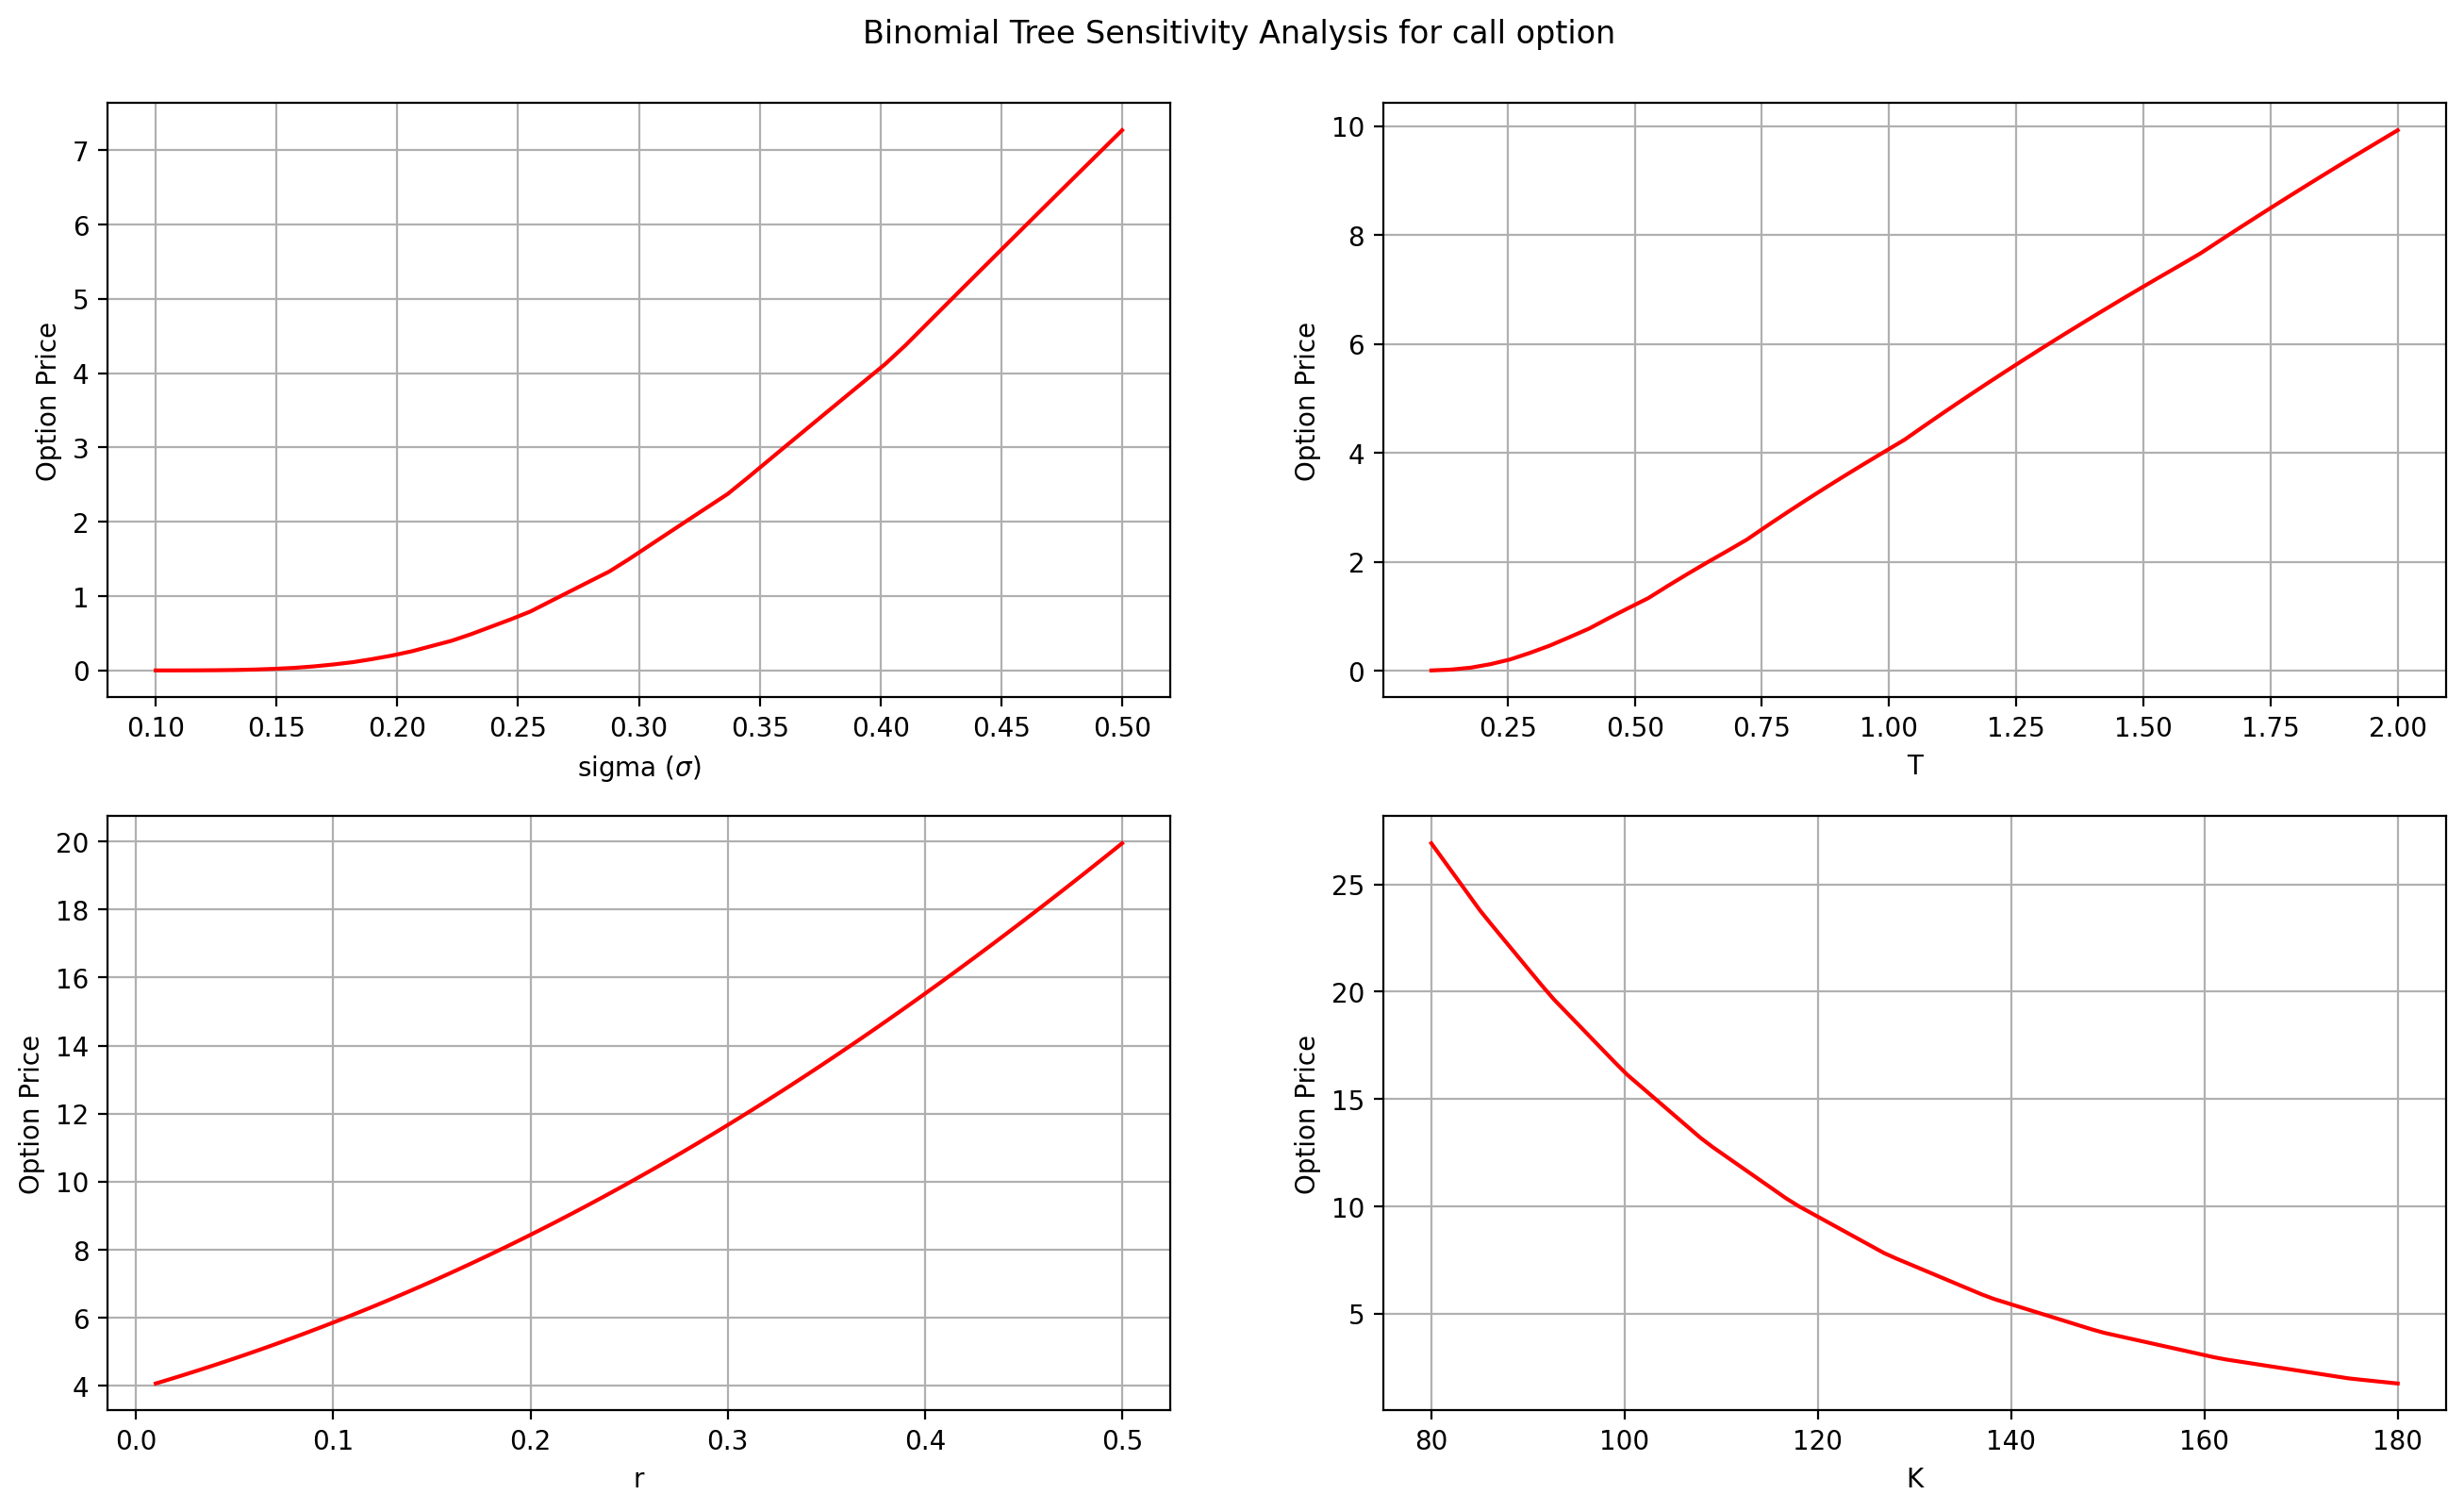

In [41]:
S = 100
K = 150
T = 1.0
r = 0.01
sigma = 0.4
N = 100

fig, axs = plt.subplots(2, 2, figsize=(16, 9))

volatility_range = np.linspace(0.1, 0.5, 50)
binomial_tree_sensitivity('sigma', volatility_range, S, K, T, r, sigma, N, 'call', axs[0, 0])

time_range = np.linspace(0.1, 2, 50)
binomial_tree_sensitivity('T', time_range, S, K, T, r, sigma, N, 'call', axs[0, 1])

rate_range = np.linspace(0.01, 0.5, 100)
binomial_tree_sensitivity('r', rate_range, S, K, T, r, sigma, N, 'call', axs[1, 0])

strike_range = np.linspace(80, 180, 80)
binomial_tree_sensitivity('K', strike_range, S, K, T, r, sigma, N, 'call', axs[1, 1])

fig.suptitle(r'Binomial Tree Sensitivity Analysis for call option', y=0.93)
plt.show()

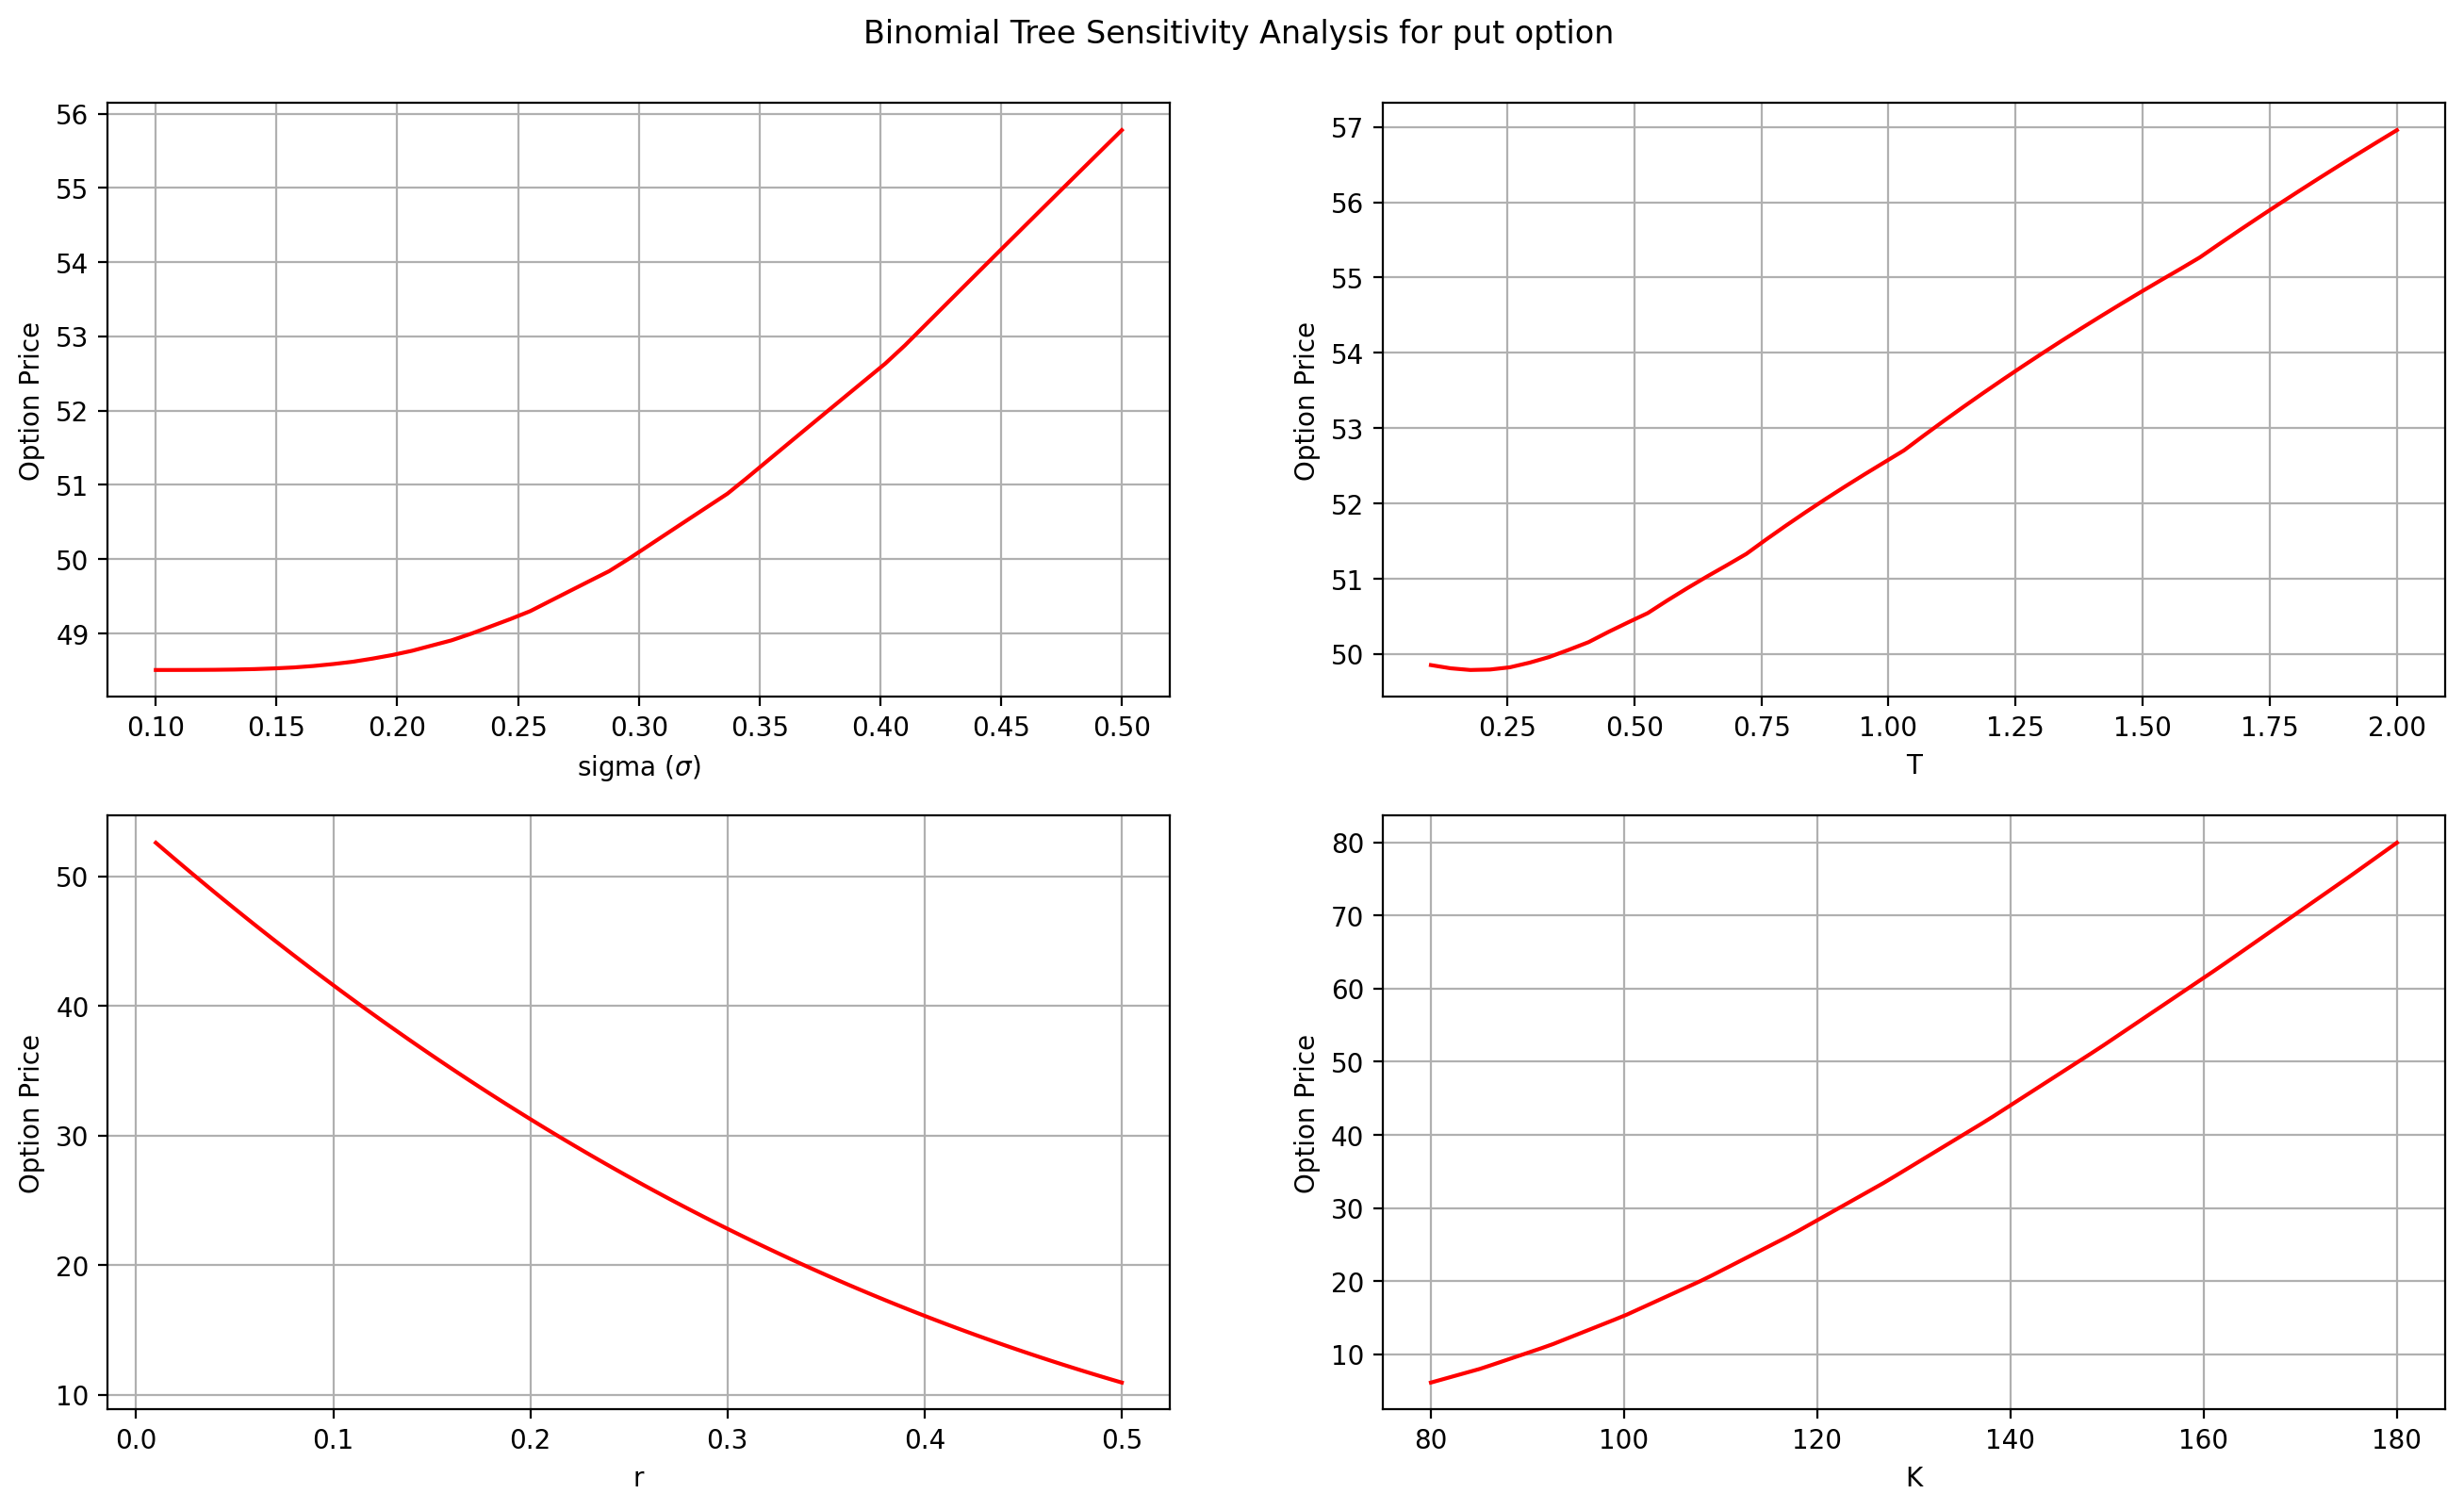

In [42]:
S = 100
K = 150
T = 1.0
r = 0.01
sigma = 0.4
N = 100

fig, axs = plt.subplots(2, 2, figsize=(16, 9))

volatility_range = np.linspace(0.1, 0.5, 50)
binomial_tree_sensitivity('sigma', volatility_range, S, K, T, r, sigma, N, 'put', axs[0, 0])

time_range = np.linspace(0.1, 2, 50)
binomial_tree_sensitivity('T', time_range, S, K, T, r, sigma, N, 'put', axs[0, 1])

rate_range = np.linspace(0.01, 0.5, 100)
binomial_tree_sensitivity('r', rate_range, S, K, T, r, sigma, N, 'put', axs[1, 0])

strike_range = np.linspace(80, 180, 80)
binomial_tree_sensitivity('K', strike_range, S, K, T, r, sigma, N, 'put', axs[1, 1])

fig.suptitle(r'Binomial Tree Sensitivity Analysis for put option', y=0.93)
plt.show()

## **Black-Scholes Model**

The Black-Scholes Model is a mathematical model for pricing European options. It provides a closed-form formula to compute the fair price of a call or put option, assuming certain market assumptions:

* Stock prices evolve continuously and log returns are normally distributed.
* No Arbitrage opportunities.
* The volatility of the underlying asset is constant, known, and option values depend on volatility.
* Markets are frictionless, which means, there are no taxes, no transaction costs, and no restriction on short sales.

The equations are:

$$ d_1 = \frac{\ln(S / K) + \left( r + \sigma^2/2 \right) T}{\sigma \sqrt{T}}, \quad
d_2 = d_1 - \sigma \sqrt{T} $$

Then we calculate call option price $C$ and put option price $P$:

$$C = S \cdot N(d_1) - K \cdot e^{-rT} \cdot N(d_2) $$

$$ P = K \cdot e^{-rT} \cdot N(-d_2) - S \cdot N(-d_1) $$

Terms:

- $S$: Current stock price  
- $K$: Strike price  
- $T$: Time to maturity (in years)  
- $r$: Risk-free interest rate (annual)  
- $\sigma$: Volatility of the stock (standard deviation)  
- $N(x)$: Cumulative distribution function of the standard normal distribution

We now implement the black scholes model:

In [43]:
def black_scholes_model(S, K, T, r, sigma, option):
    d1 = (log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)

    if option == 'call':
        price = S * norm.cdf(d1) - K * exp(-r*T) * norm.cdf(d2)
    else:
        price = K * exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)

    return price

## **Option Greeks**

The option greeks based on Black-Scholes Model are as follows:

* Delta: Sensitivity of the option's price to a small change in the underlying stock price.

$$ \Delta_{\text{call}} = N(d_1), \quad \Delta_{\text{put}} = -N(-d_1) $$

* Gamma: Sensitivity of Delta to changes in the stock price.

$$ \Gamma = \frac{N'(d_1)}{S \sigma \sqrt{T}} $$

* Vega: Sensitivity of the option's price to changes in volatility.

$$\text{Vega} = S \cdot N'(d_1) \cdot \sqrt{T}$$

* Theta: Sensitivity of the option's price to time decay.

$$ \Theta_{\text{call}} = \frac{-S N'(d_1) \sigma}{2 \sqrt{T}} - rK e^{-rT} N(d_2), \quad \Theta_{\text{put}} = \frac{-S N'(d_1) \sigma}{2 \sqrt{T}} + rK e^{-rT} N(-d_2)$$

* Rho: Sensitivity of the option's price to changes in the risk-free interest rate.

$$ \rho_{\text{call}} = K T e^{-rT} N(d_2), \quad \rho_{\text{put}} = -K T e^{-rT} N(-d_2)$$

where $N'(x)$ is pdf of standard normal distribution, and other symbols have their usual meanings.


In [44]:
def black_scholes_greeks(S, K, T, r, sigma, option):
    d1 = (log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    nd1 = norm.pdf(d1)

    if option == 'call':
        delta = norm.cdf(d1)
        theta = -(S * nd1 * sigma) / (2 * sqrt(T)) - r * K * exp(-r*T) * norm.cdf(d2)
        rho   = K * T * exp(-r*T) * norm.cdf(d2)
    else:
        delta = -norm.cdf(-d1)
        theta = -(S * nd1 * sigma) / (2 * sqrt(T)) + r * K * exp(-r*T) * norm.cdf(-d2)
        rho   = -K * T * exp(-r*T) * norm.cdf(-d2)

    gamma = nd1 / (S * sigma * sqrt(T))
    vega  = S * sqrt(T) * nd1

    return {'Delta': delta, 'Gamma': gamma, 'Theta': theta, 'Vega': vega, 'Rho': rho}

## **Black-Scholes model sensitivity**

We write a function to plot Black-Scholes model sensitivity against key parameters $K, T, r, \sigma$.

In [45]:
def black_scholes_sensitivity(param_name, param_range, S, K, T, r, sigma, option, ax):
    prices = []
    for param in param_range:
        if param_name == 'sigma':
            prices.append(black_scholes_model(S, K, T, r, param, option))
        elif param_name == 'T':
            prices.append(black_scholes_model(S, K, param, r, sigma, option))
        elif param_name == 'r':
            prices.append(black_scholes_model(S, K, T, param, sigma, option))
        elif param_name == 'K':
            prices.append(black_scholes_model(S, param, T, r, sigma, option))

    ax.plot(param_range, prices, label='Black-Scholes')
    if(param_name == 'sigma'):
        param_name = 'sigma ($\sigma$)'
    ax.set_xlabel(param_name)
    ax.set_ylabel('Option Price')
    ax.grid(True)

We fix the initial values of $S, K, T, r, \sigma$ and vary the key parameters for both call and put options, and plot the results.

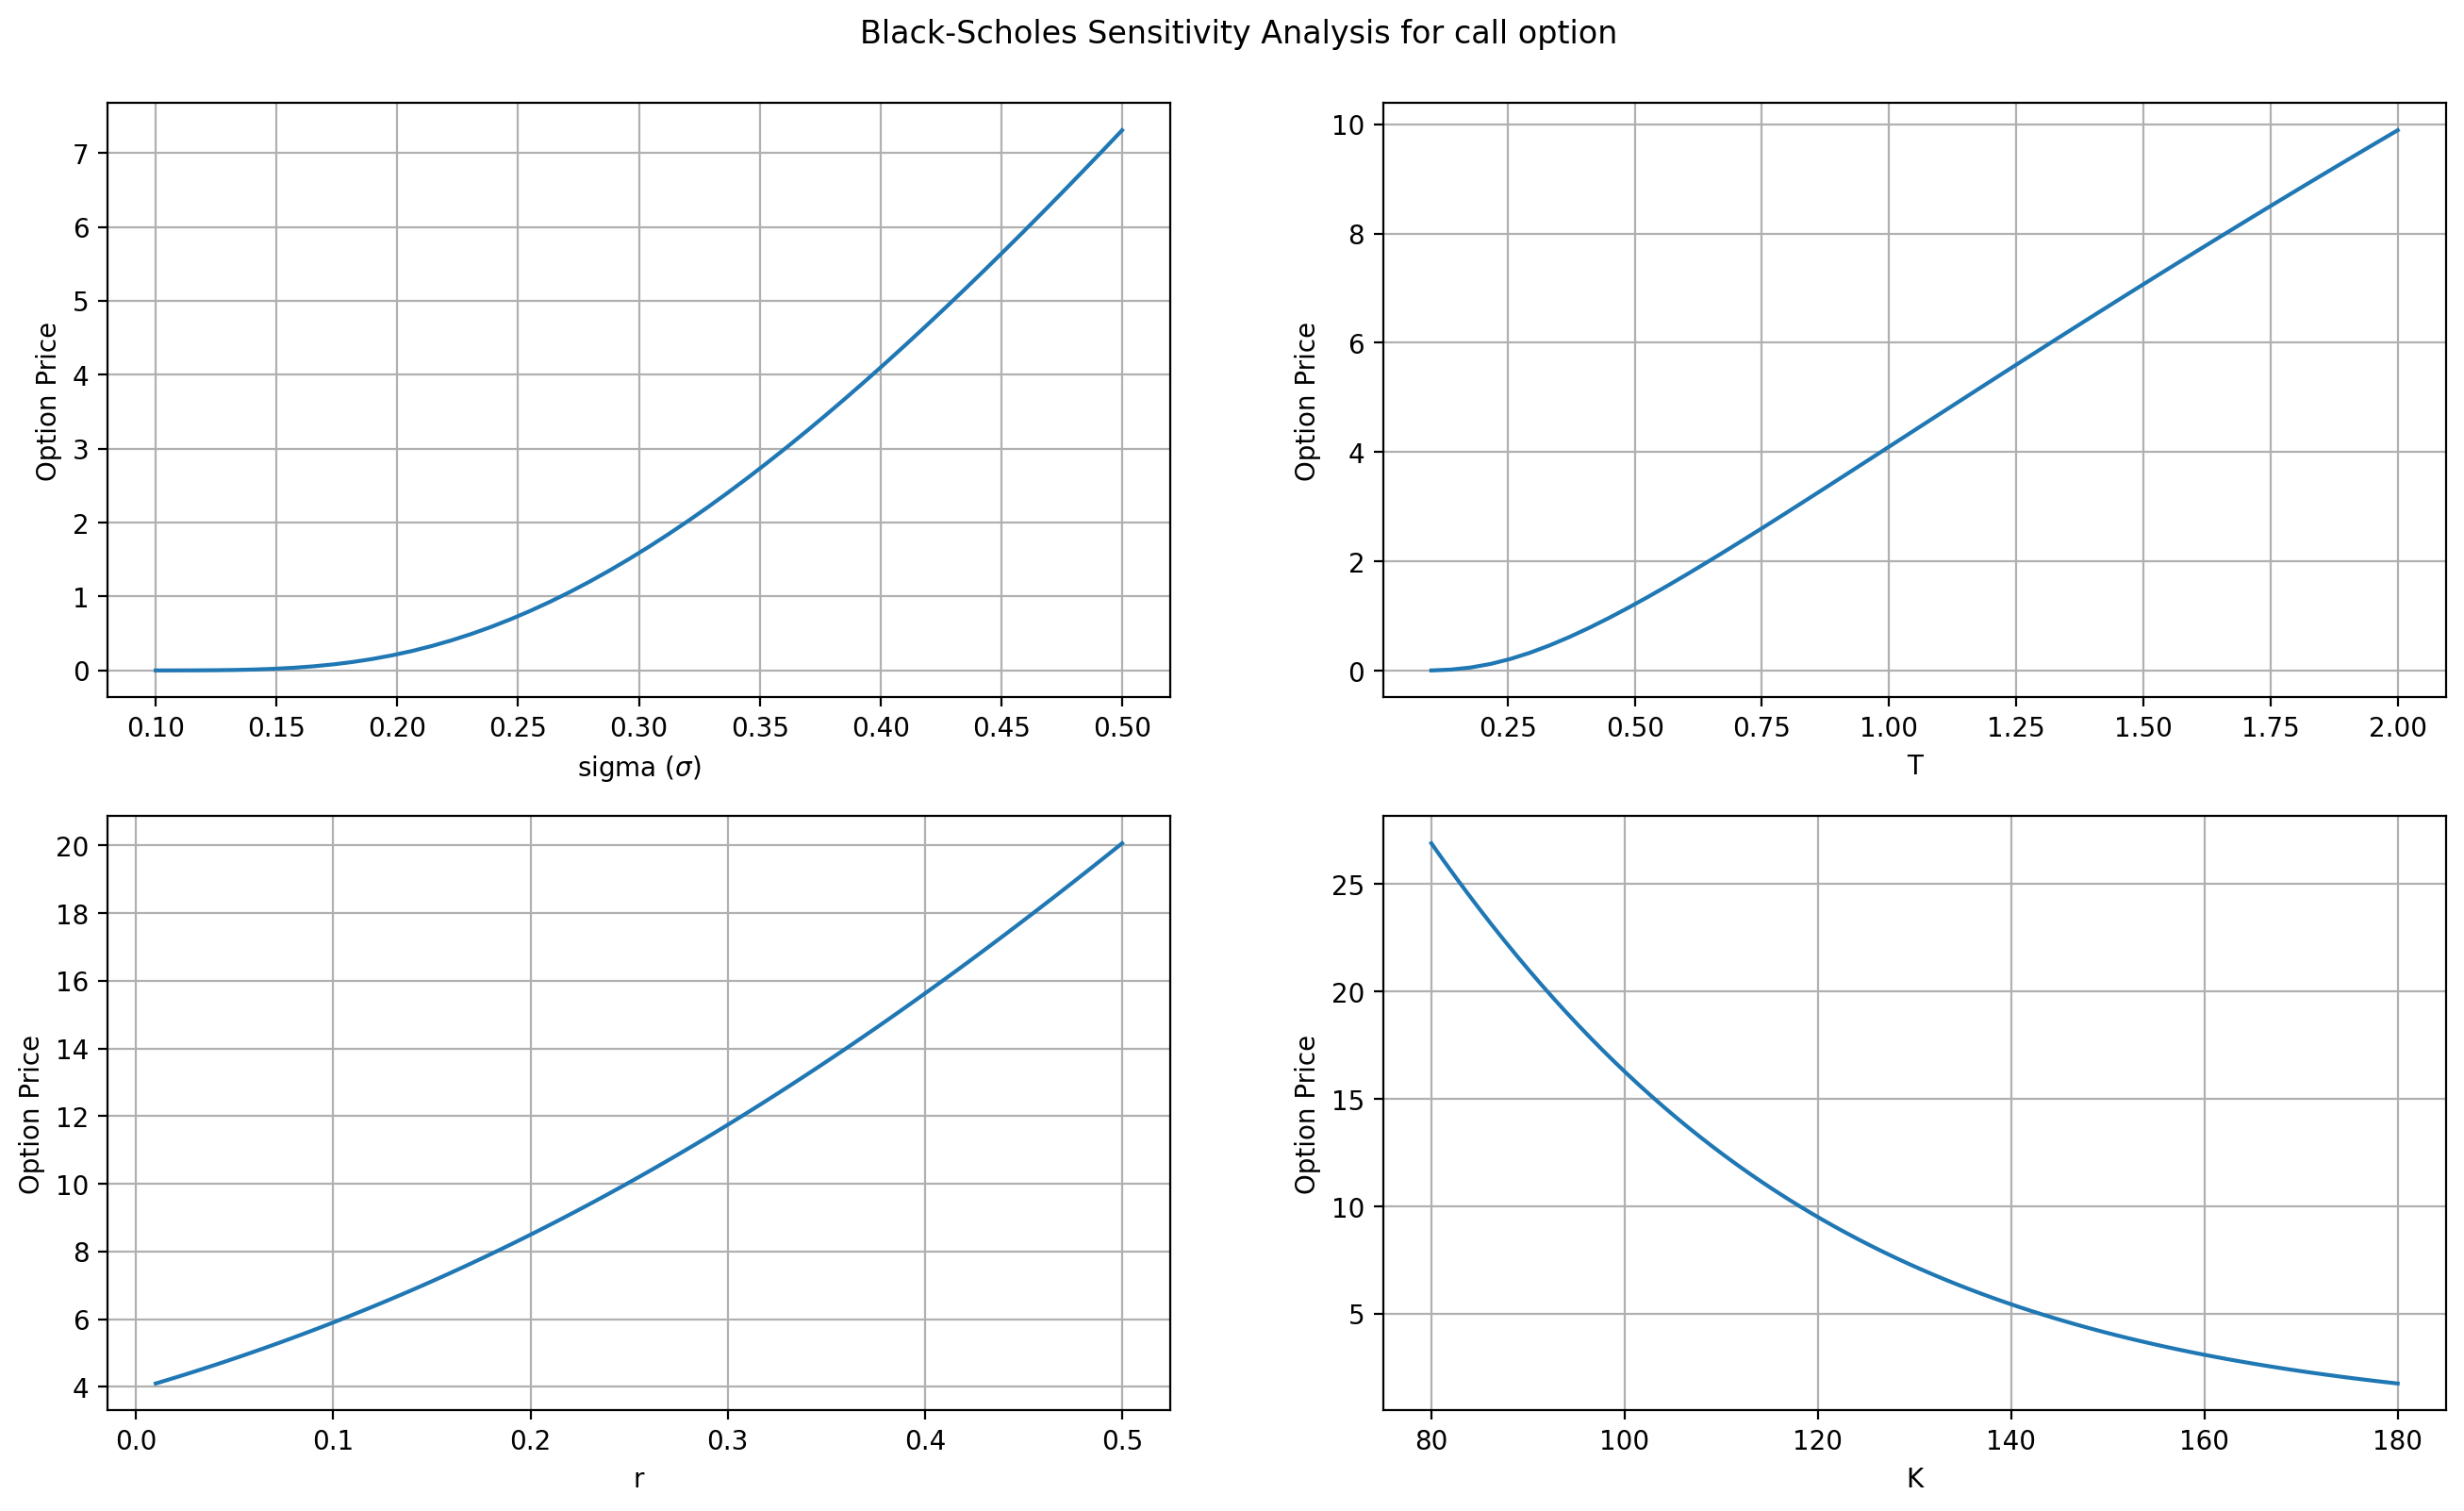

In [46]:
S = 100
K = 150
T = 1.0
r = 0.01
sigma = 0.4

fig, axs = plt.subplots(2, 2, figsize=(16, 9))

volatility_range = np.linspace(0.1, 0.5, 50)
black_scholes_sensitivity('sigma', volatility_range, S, K, T, r, sigma, 'call', axs[0, 0])

time_range = np.linspace(0.1, 2, 50)
black_scholes_sensitivity('T', time_range, S, K, T, r, sigma, 'call', axs[0, 1])

rate_range = np.linspace(0.01, 0.5, 100)
black_scholes_sensitivity('r', rate_range, S, K, T, r, sigma, 'call', axs[1, 0])

strike_range = np.linspace(80, 180, 80)
black_scholes_sensitivity('K', strike_range, S, K, T, r, sigma, 'call', axs[1, 1])

fig.suptitle(r'Black-Scholes Sensitivity Analysis for call option', y=0.93)
plt.show()

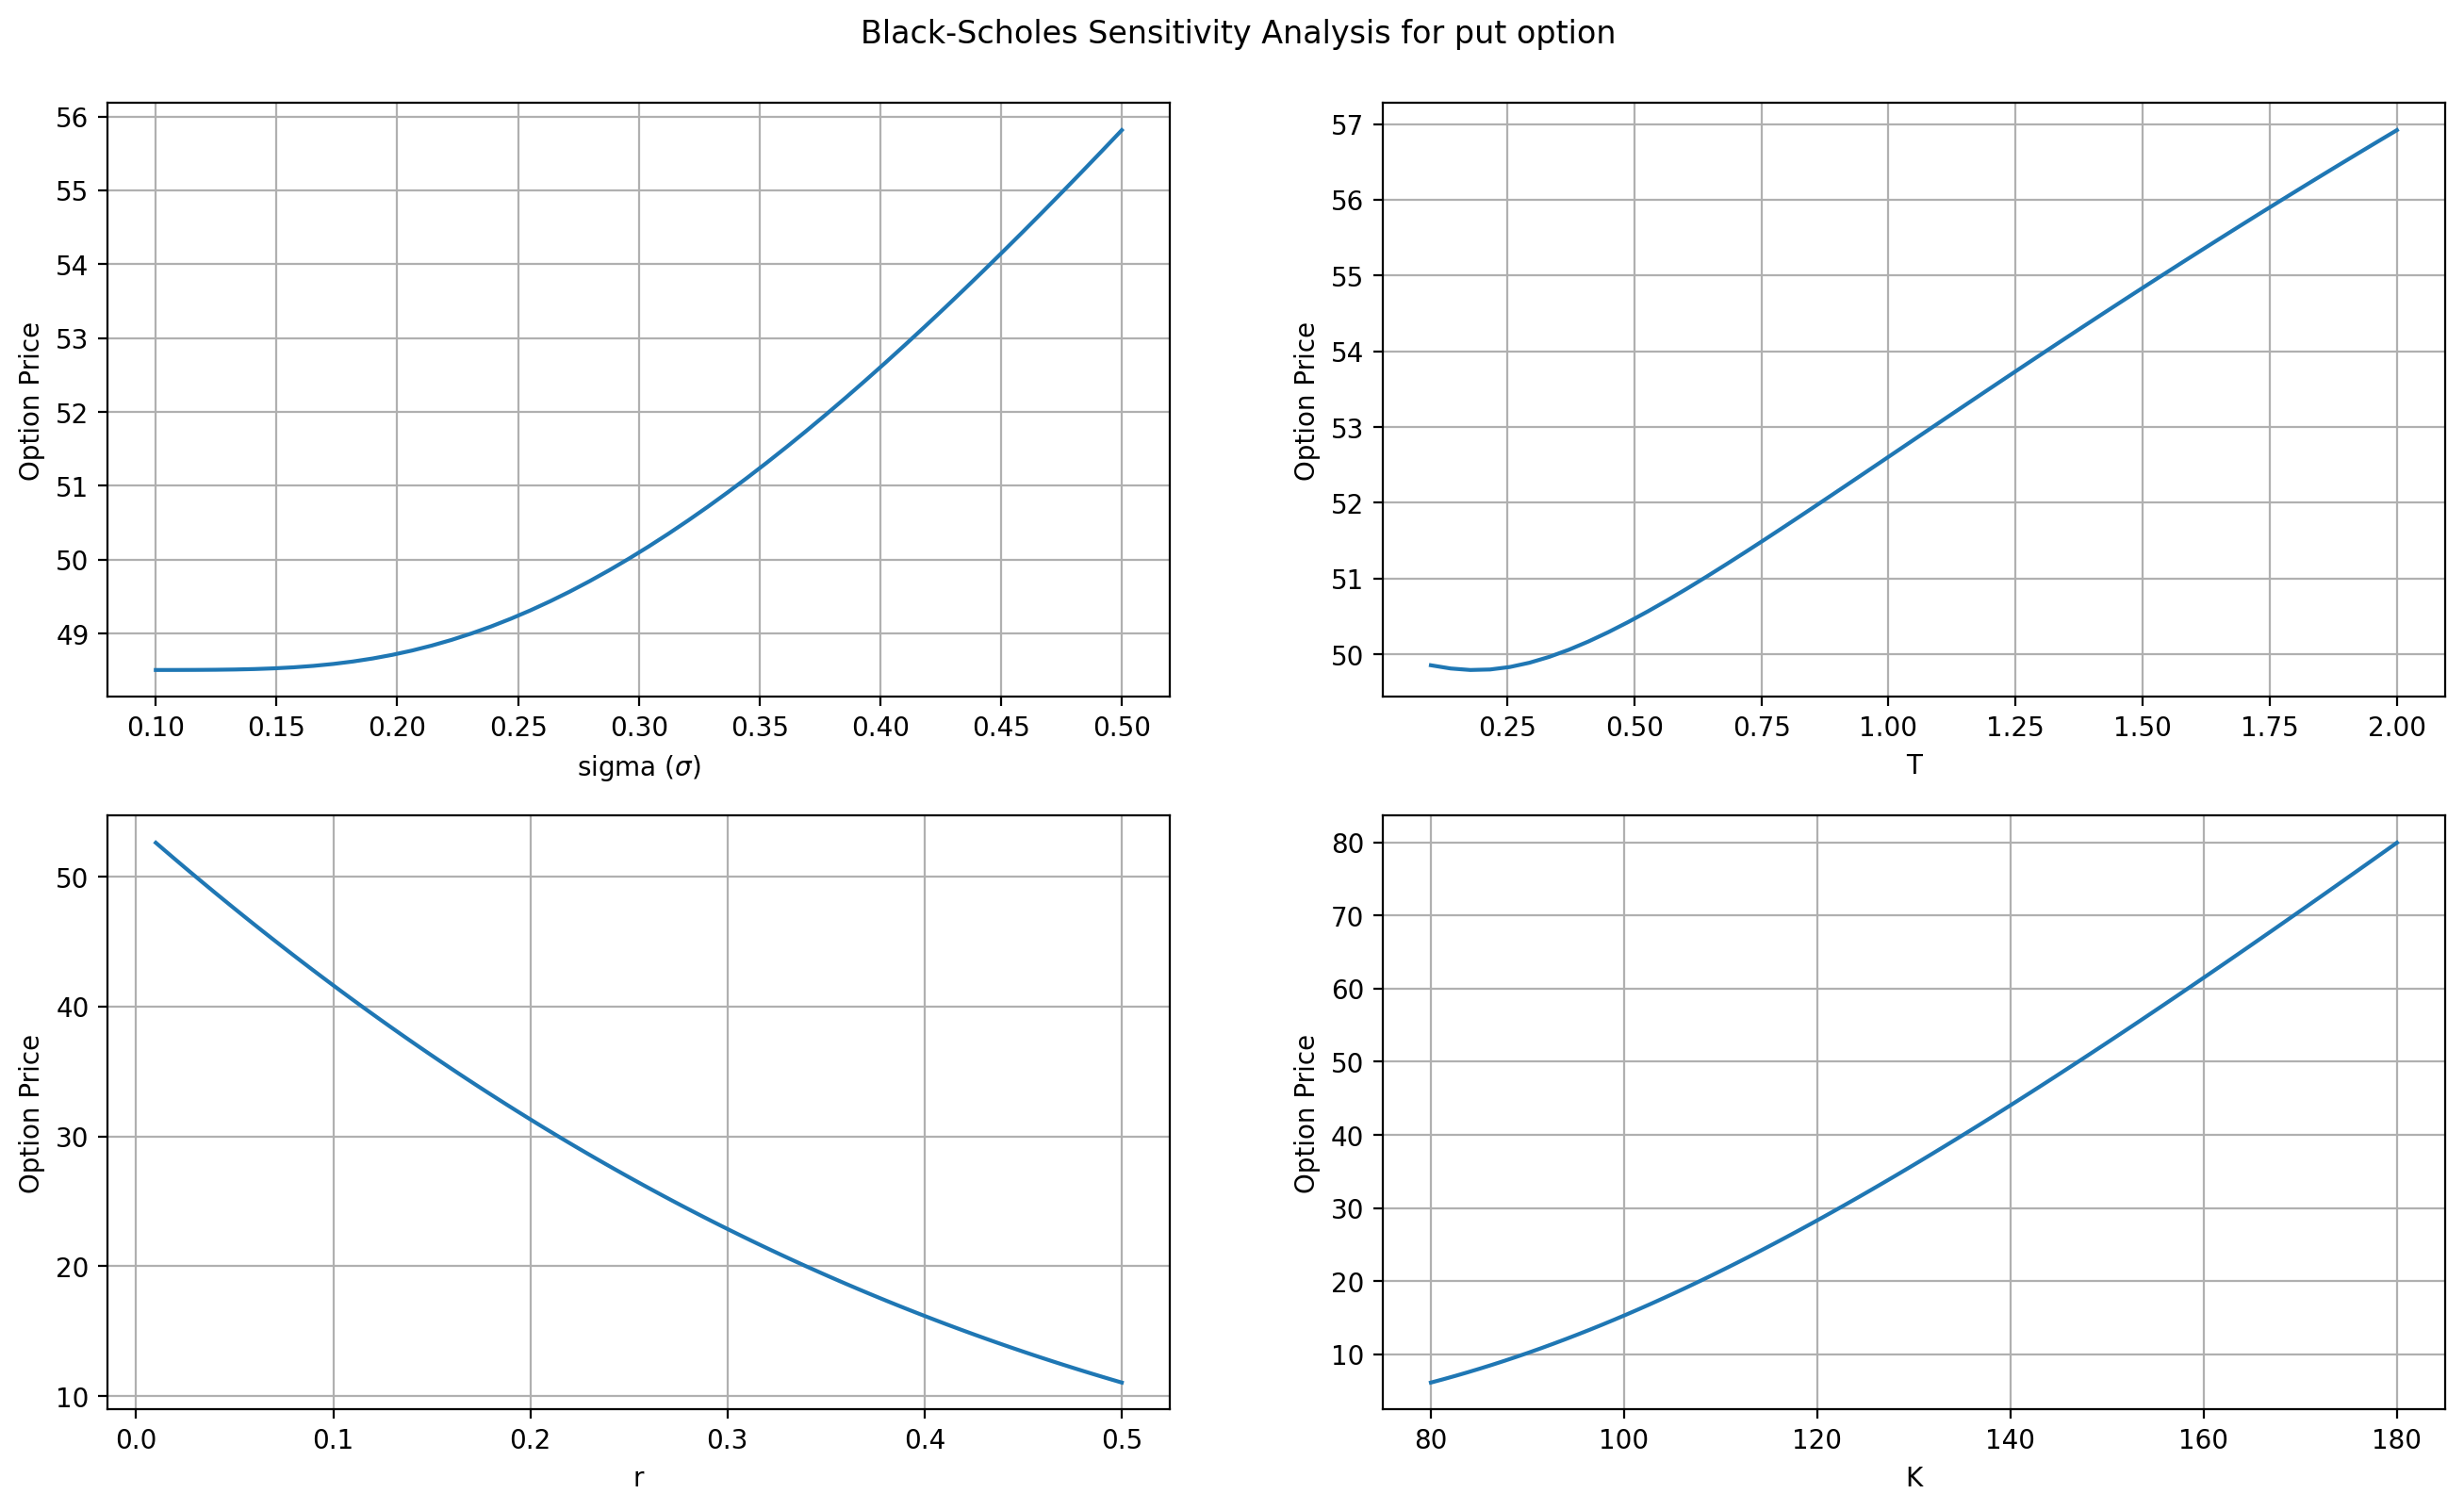

In [47]:
S = 100
K = 150
T = 1.0
r = 0.01
sigma = 0.4

fig, axs = plt.subplots(2, 2, figsize=(16, 9))

volatility_range = np.linspace(0.1, 0.5, 50)
black_scholes_sensitivity('sigma', volatility_range, S, K, T, r, sigma, 'put', axs[0, 0])

time_range = np.linspace(0.1, 2, 50)
black_scholes_sensitivity('T', time_range, S, K, T, r, sigma, 'put', axs[0, 1])

rate_range = np.linspace(0.01, 0.5, 100)
black_scholes_sensitivity('r', rate_range, S, K, T, r, sigma, 'put', axs[1, 0])

strike_range = np.linspace(80, 180, 80)
black_scholes_sensitivity('K', strike_range, S, K, T, r, sigma, 'put', axs[1, 1])

fig.suptitle(r'Black-Scholes Sensitivity Analysis for put option', y=0.93)
plt.show()

## **Convergence of pricing of Binomial Tree Model and Black-Scholes Model**

As the number of time steps $N$ increases, the binomial tree model price for European options converges to the Black-Scholes price. It converges because binomial tree model provides a discrete-time approximation to the continuous process underlying the Black-Scholes model, and as the number of time steps in the binomial tree increases, the discrete movements in the price follow a binomial distribution, which approaches the log-normal distribution assumed by Black-Scholes.

To plot the price convergence, we fix the parameters and vary the number of time steps $N$ of binomial tree model and get the prices for each time step. We then plot the prices given by binomial tree and the Black-Scholes price (which is fixed) for both call and put options.



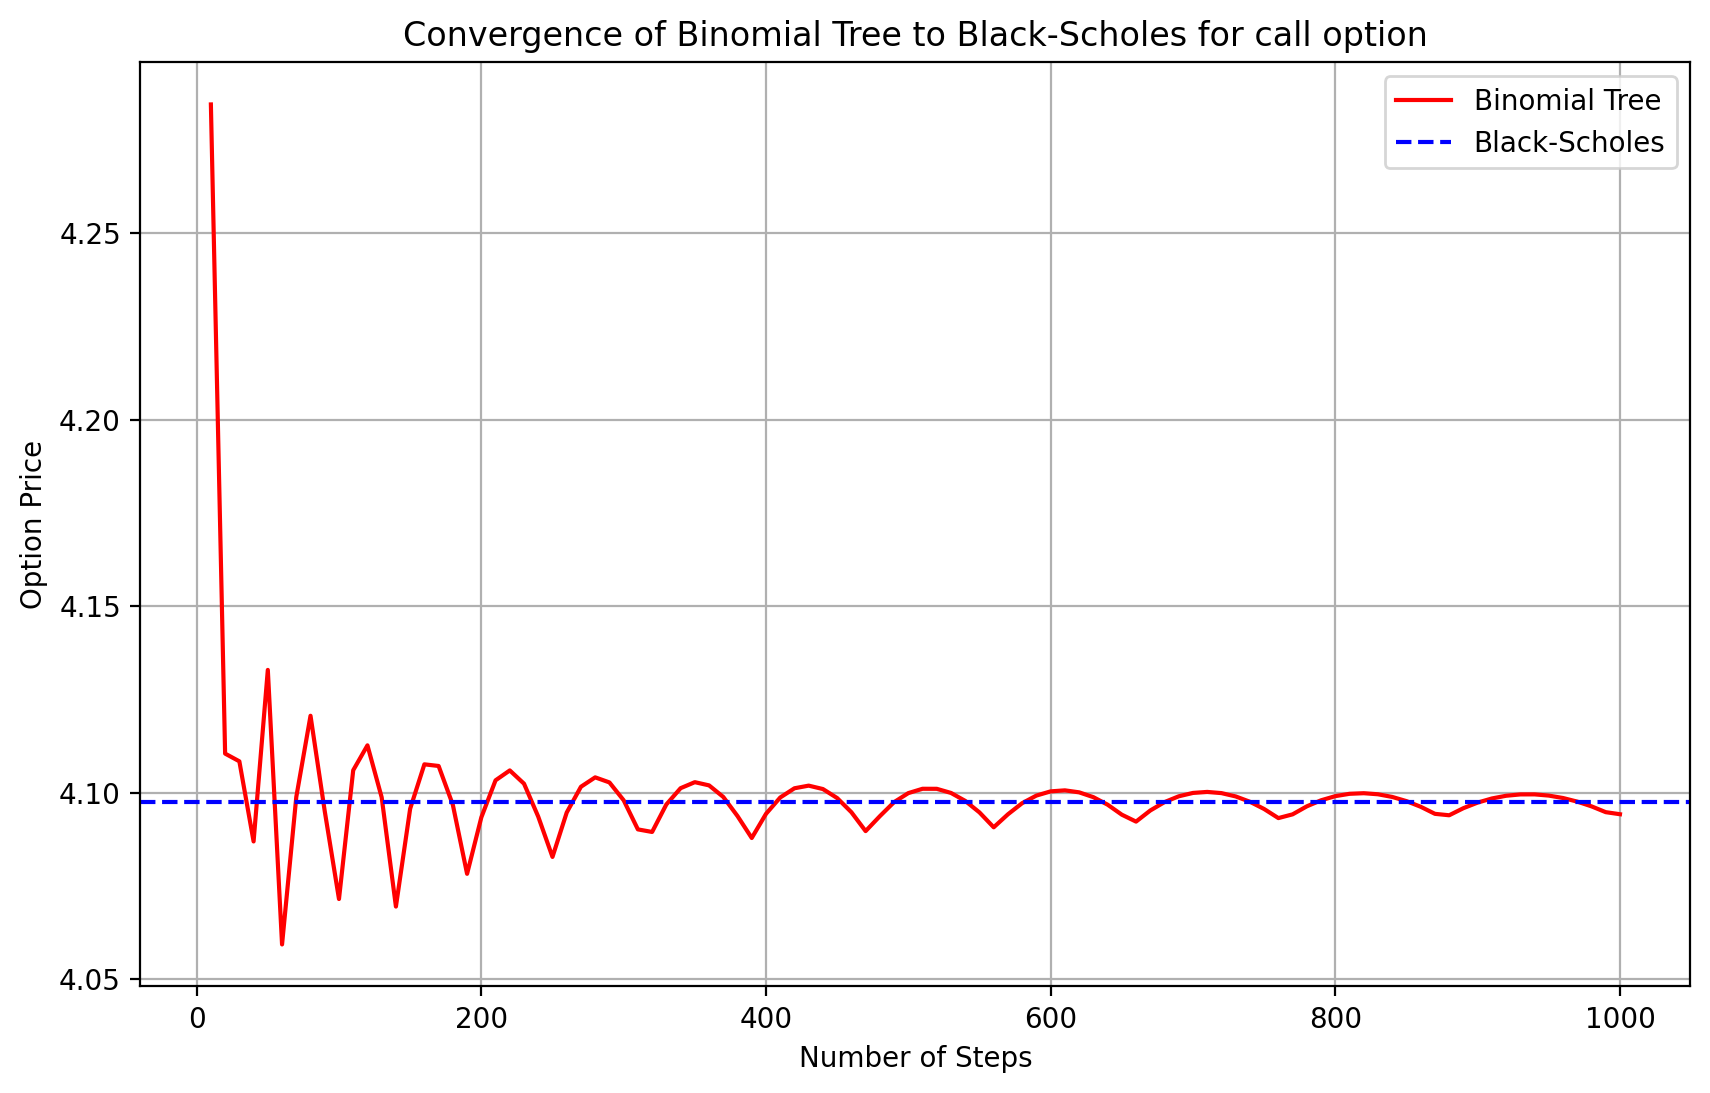

In [48]:
S = 100
K = 150
T = 1.0
r = 0.01
sigma = 0.4

bs_call = black_scholes_model(S, K, T, r, sigma, 'call')

steps = np.arange(10, 1001, 10)
bin_prices = []

for N in steps:
    price = binomial_tree_model(S, K, T, r, sigma, N, 'call')
    bin_prices.append(price)

plt.figure(figsize=(10, 6))
plt.plot(steps, bin_prices, 'r', label='Binomial Tree')
plt.axhline(y=bs_call, color='b', linestyle='--', label='Black-Scholes')
plt.xlabel('Number of Steps')
plt.ylabel('Option Price')
plt.title('Convergence of Binomial Tree to Black-Scholes for call option')
plt.legend()
plt.grid(True)
plt.show()

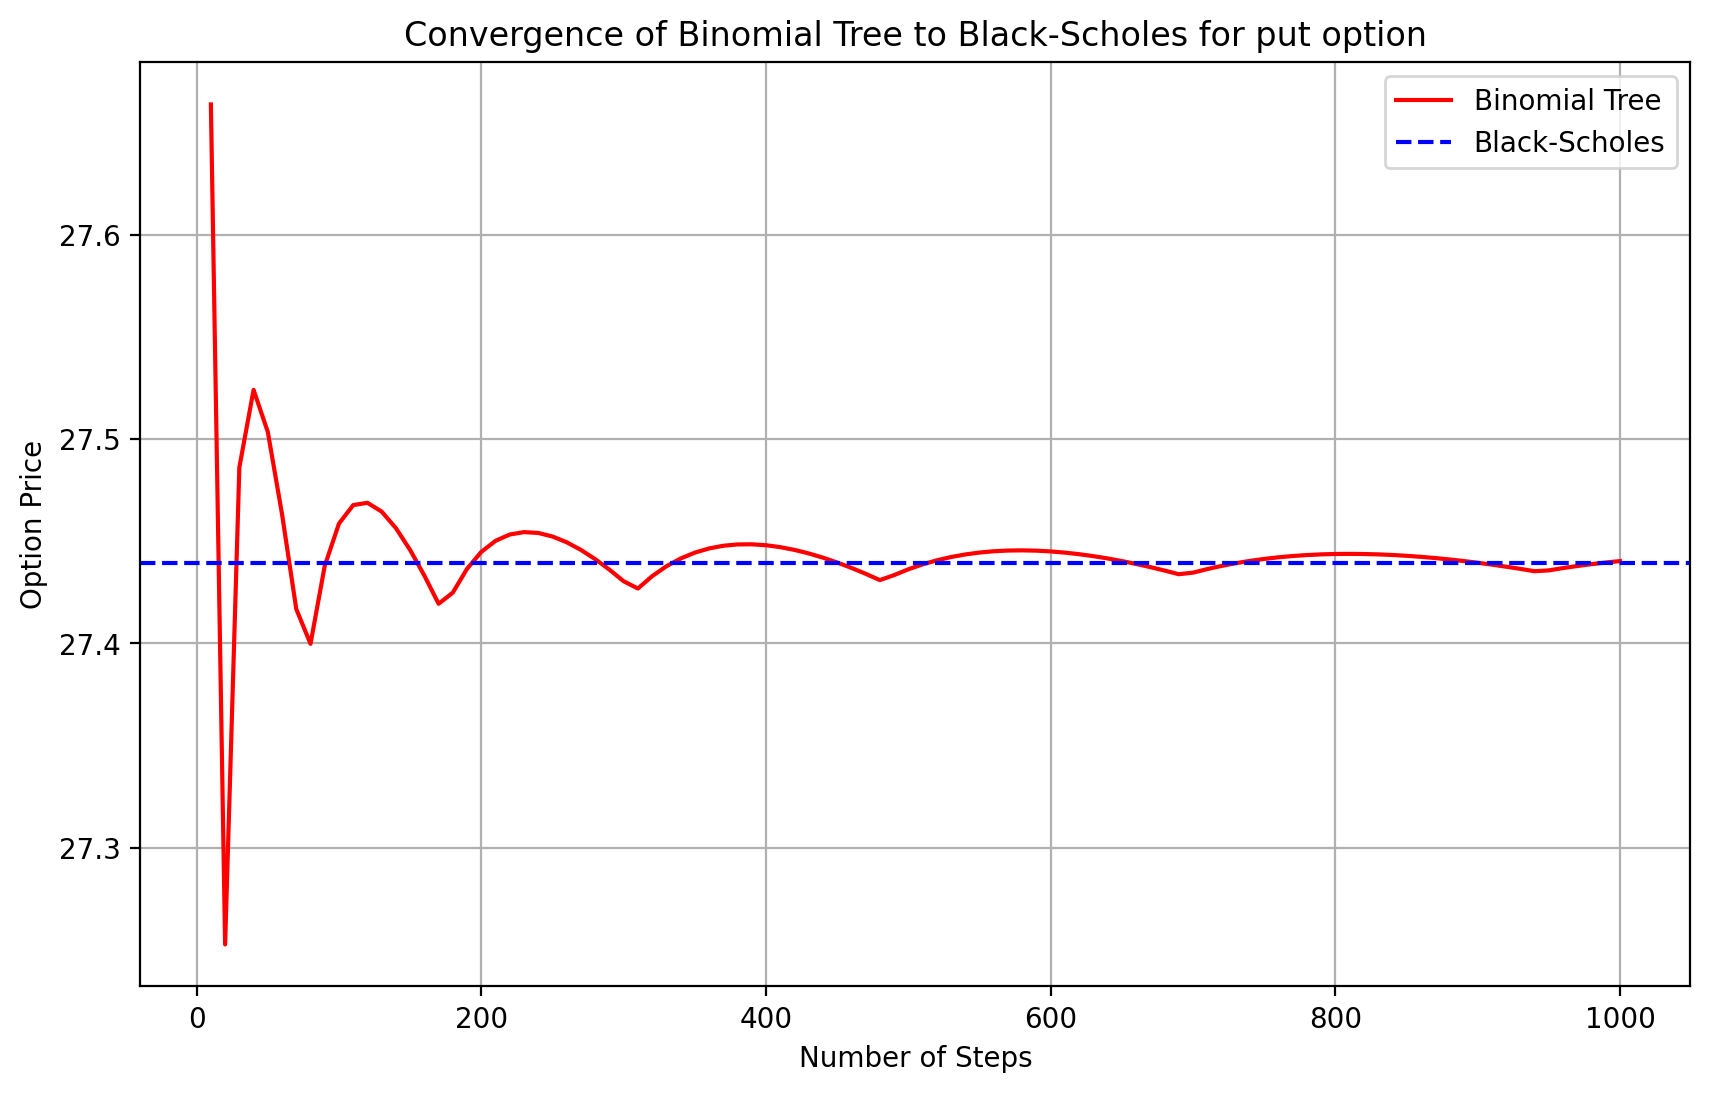

In [51]:
S = 100
K = 120
T = 1.0
r = 0.02
sigma = 0.4

bs_put = black_scholes_model(S, K, T, r, sigma, 'put')

steps = np.arange(10, 1001, 10)
bin_prices = []

for N in steps:
    price = binomial_tree_model(S, K, T, r, sigma, N, 'put')
    bin_prices.append(price)

plt.figure(figsize=(10, 6))
plt.plot(steps, bin_prices, 'r', label='Binomial Tree')
plt.axhline(y=bs_put, color='b', linestyle='--', label='Black-Scholes')
plt.xlabel('Number of Steps')
plt.ylabel('Option Price')
plt.title('Convergence of Binomial Tree to Black-Scholes for put option')
plt.legend()
plt.grid(True)
plt.show()